In [4]:
try:
    from rich import load_ipython_extension
    %load_ext rich
except ImportError:
    try:
        from rich import pretty
        pretty.install()
    except ImportError:
        pass

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

Using the cleaned dataset created in assignment 1

In [6]:
data = pd.read_csv("../data/manipulated_data.csv")
data

,sex,age,income_bracket,year,total_sum_sek_millions,number_of_persons,region_name,level_of_education
0,Man,16-19,TOT,2018,547.9,38091,Stockholm,primary/lower secondary
1,Man,16-19,0,2018,0.0,13357,Stockholm,primary/lower secondary
2,Man,16-19,1-19,2018,137.9,17417,Stockholm,primary/lower secondary
3,Man,16-19,20-39,2018,106.1,3763,Stockholm,primary/lower secondary
4,Man,16-19,40-59,2018,77.2,1574,Stockholm,primary/lower secondary
...,...,...,...,...,...,...,...,...
409255,Woman,65-69,80-99,2012,0.9,10,Norrbotten,unknown
409256,Woman,70-75,TOT,2012,2.4,36,Norrbotten,unknown
409257,Woman,70-75,0,2012,0.0,11,Norrbotten,unknown
409258,Woman,70-75,1-19,2012,0.1,6,Norrbotten,unknown


Checking data types

In [7]:
data.dtypes


sex                        object
age                        object
income_bracket             object
year                        int64
total_sum_sek_millions    float64
number_of_persons           int64
region_name                object
level_of_education         object
dtype: object

To set data types correctly for each column the function and type map from assignment 1 is used.

In [35]:
def convert_types(type_map, df):
    for item in type_map.items():
        if item[1] == "int64":
            df[item[0]] = pd.to_numeric(df[item[0]], errors="coerce").astype("Int64")
        elif item[1] == "float64":
            df[item[0]] = pd.to_numeric(df[item[0]], errors="coerce").astype("float64")
        elif item[1] == "string":
            df[item[0]] = df[item[0]].astype("string")

In [9]:
type_map_data = {
    "region_name": "string",
    "level_of_education": "string",
    "sex": "string",
    "age": "string",
    "income_bracket": "string",
    "year": "int64",
    "total_sum_sek_millions": "float64",
    "number_of_persons": "int64",
}

convert_types(type_map_data, data)
data.dtypes


sex                       string[python]
age                       string[python]
income_bracket            string[python]
year                               Int64
total_sum_sek_millions           float64
number_of_persons                  Int64
region_name               string[python]
level_of_education        string[python]
dtype: object

I will try to classify which age the test instances has based on their features.

In [10]:
data["age"].unique().tolist()

['16-19', '20-29', '30-39', '40-49', '50-59', '60-64', '65-69', '70-75']

Number of instances for each age bin

In [11]:
data["age"].value_counts()


age
30-39    58938
40-49    57395
20-29    57333
50-59    55641
60-64    53044
65-69    52566
70-75    50595
16-19    23748
Name: count, dtype: Int64

Removing the TOT rows from income bracket beacause I believe it will not help the model and it doesn't make sense to keep it for this task.

In [12]:
data = data[data["income_bracket"] != "TOT"]

data

,sex,age,income_bracket,year,total_sum_sek_millions,number_of_persons,region_name,level_of_education
1,Man,16-19,0,2018,0.0,13357,Stockholm,primary/lower secondary
2,Man,16-19,1-19,2018,137.9,17417,Stockholm,primary/lower secondary
3,Man,16-19,20-39,2018,106.1,3763,Stockholm,primary/lower secondary
4,Man,16-19,40-59,2018,77.2,1574,Stockholm,primary/lower secondary
5,Man,16-19,60-79,2018,50.9,745,Stockholm,primary/lower secondary
...,...,...,...,...,...,...,...,...
409254,Woman,65-69,1-19,2012,0.0,4,Norrbotten,unknown
409255,Woman,65-69,80-99,2012,0.9,10,Norrbotten,unknown
409257,Woman,70-75,0,2012,0.0,11,Norrbotten,unknown
409258,Woman,70-75,1-19,2012,0.1,6,Norrbotten,unknown


Age map for hopefully boosting performance a bit.

In [13]:
age_map = {"16-19": 0, "20-29": 1, "30-39": 2, "40-49": 3, "50-59": 4, "60-64": 5, "65-69": 6, "70-75": 7}

In [14]:
data = data.copy()
data["age"] = data["age"].map(age_map).astype("int64")

data["age"].unique().tolist()

[0, 1, 2, 3, 4, 5, 6, 7]

In [15]:
labels = data[["age"]]
labels

,age
1,0
2,0
3,0
4,0
5,0
...,...
409254,6
409255,6
409257,7
409258,7


I will use all features in the first experiment.

In [16]:
features = data.drop(columns="age")
features

,sex,income_bracket,year,total_sum_sek_millions,number_of_persons,region_name,level_of_education
1,Man,0,2018,0.0,13357,Stockholm,primary/lower secondary
2,Man,1-19,2018,137.9,17417,Stockholm,primary/lower secondary
3,Man,20-39,2018,106.1,3763,Stockholm,primary/lower secondary
4,Man,40-59,2018,77.2,1574,Stockholm,primary/lower secondary
5,Man,60-79,2018,50.9,745,Stockholm,primary/lower secondary
...,...,...,...,...,...,...,...
409254,Woman,1-19,2012,0.0,4,Norrbotten,unknown
409255,Woman,80-99,2012,0.9,10,Norrbotten,unknown
409257,Woman,0,2012,0.0,11,Norrbotten,unknown
409258,Woman,1-19,2012,0.1,6,Norrbotten,unknown


Below I group the dataset by `level_of_education`, summing `total_sum_sek_millions` and `number_of_persons` for each education level.
Then plots each education level as a point, with `number_of_persons` on the x-axis and `total_sum_sek_millions` on the y-axis. Each point is colored by education level.
And fits a linear regression model to predict total income (`total_sum_sek_millions`) from population size (`number_of_persons`), using the aggregated data.
I include the regression line in the scatterplot.

This is done to visualize and model the relationship between population size and total income for each education level, showing both the data points and the overall trend.

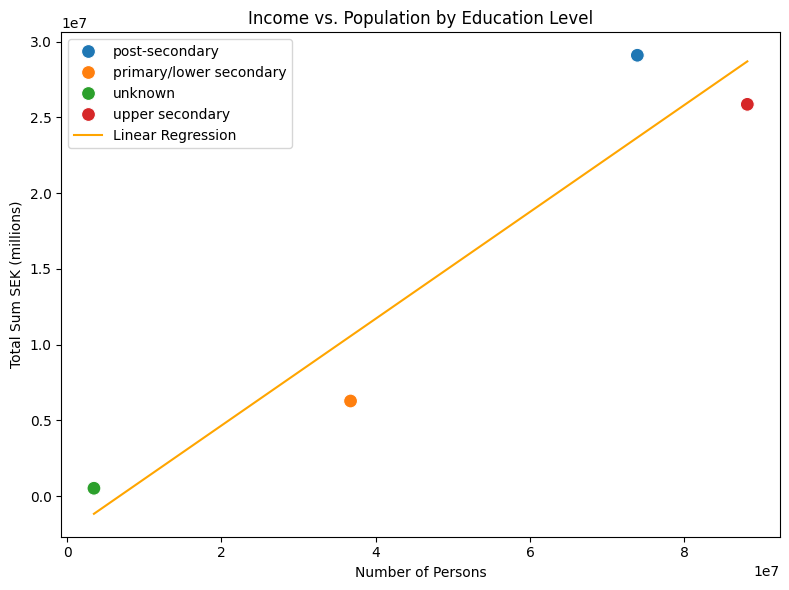

In [ ]:
edu_group = (
    data.groupby("level_of_education").agg({"total_sum_sek_millions": "sum", "number_of_persons": "sum"}).reset_index()
)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="number_of_persons",
    y="total_sum_sek_millions",
    data=edu_group,
    hue="level_of_education",
    palette="tab10",
    s=100,
)

X = edu_group[["number_of_persons"]]
y = edu_group["total_sum_sek_millions"]
model = LinearRegression()
model.fit(X, y)
xfit = np.linspace(X.min(), X.max(), 100)
xfit_df = pd.DataFrame(xfit, columns=["number_of_persons"])
yfit = model.predict(xfit_df)
plt.plot(xfit, yfit, color="orange", label="Linear Regression")

plt.xlabel("Number of Persons")
plt.ylabel("Total Sum SEK (millions)")
plt.title("Income vs. Population by Education Level")
plt.legend()
plt.tight_layout()
plt.show()

This code groups the data by region and education, calculates average income per person, clusters the groups into 4 clusters using k-means, and visualizes the clusters on a log-log scatterplot. This helps to identify patterns or groupings among regions based on income and population, with additional context from education levels.

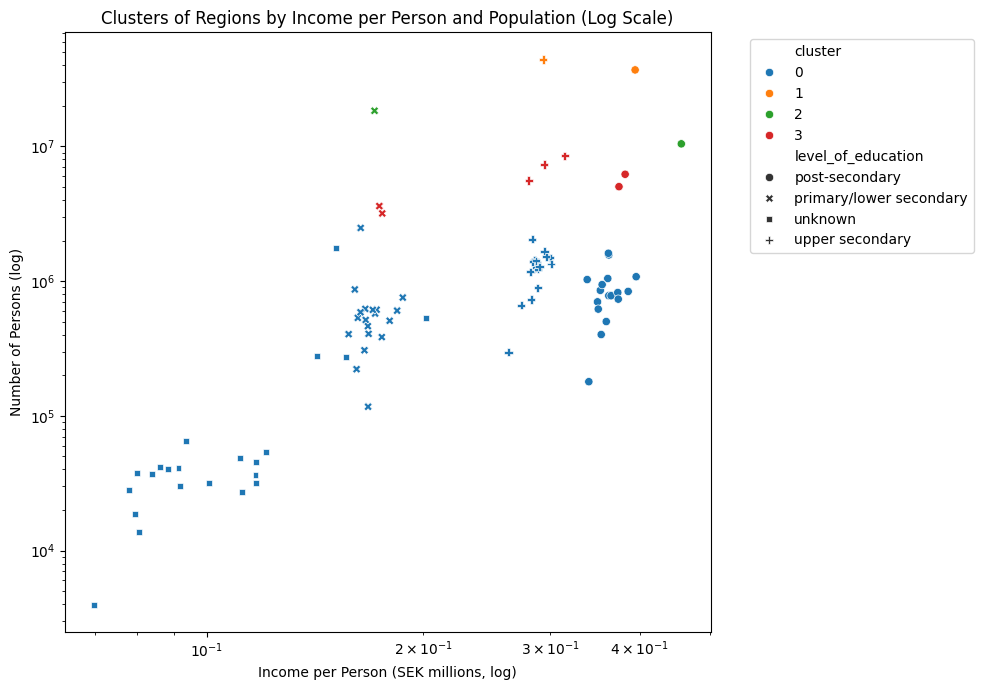

In [ ]:
agg = (
    data.groupby(["region_name", "level_of_education"])
    .agg({"total_sum_sek_millions": "sum", "number_of_persons": "sum"})
    .reset_index()
)

agg["income_per_person"] = agg["total_sum_sek_millions"] / agg["number_of_persons"]

X_agg = agg[["income_per_person", "number_of_persons"]].fillna(0)

kmeans = KMeans(n_clusters=4, random_state=42)
agg["cluster"] = kmeans.fit_predict(X_agg)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="income_per_person", y="number_of_persons", hue="cluster", style="level_of_education", data=agg, palette="tab10"
)
plt.xscale("log")
plt.yscale("log")
plt.title("Clusters of Regions by Income per Person and Population (Log Scale)")
plt.xlabel("Income per Person (SEK millions, log)")
plt.ylabel("Number of Persons (log)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

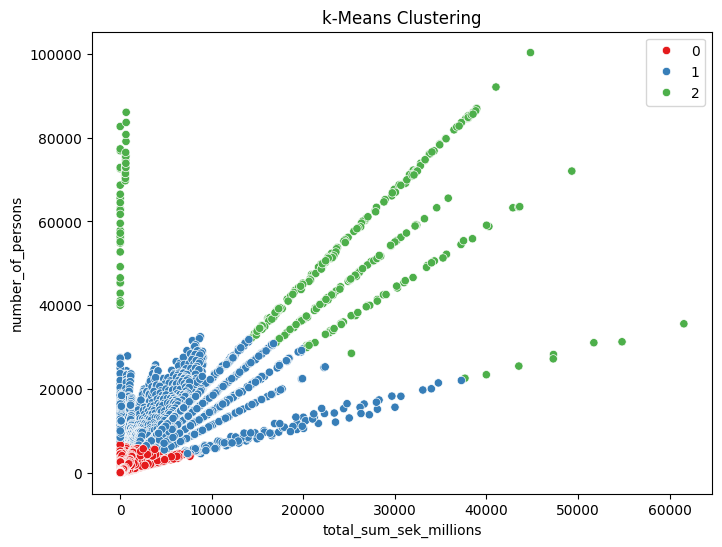

In [ ]:


X_cluster = data[["total_sum_sek_millions", "number_of_persons"]]

# Choose number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_cluster)

plt.figure(figsize=(8, 6))
sns.scatterplot(x="total_sum_sek_millions", y="number_of_persons", data=data, hue=clusters, palette="Set1")
plt.title("k-Means Clustering")
plt.show()

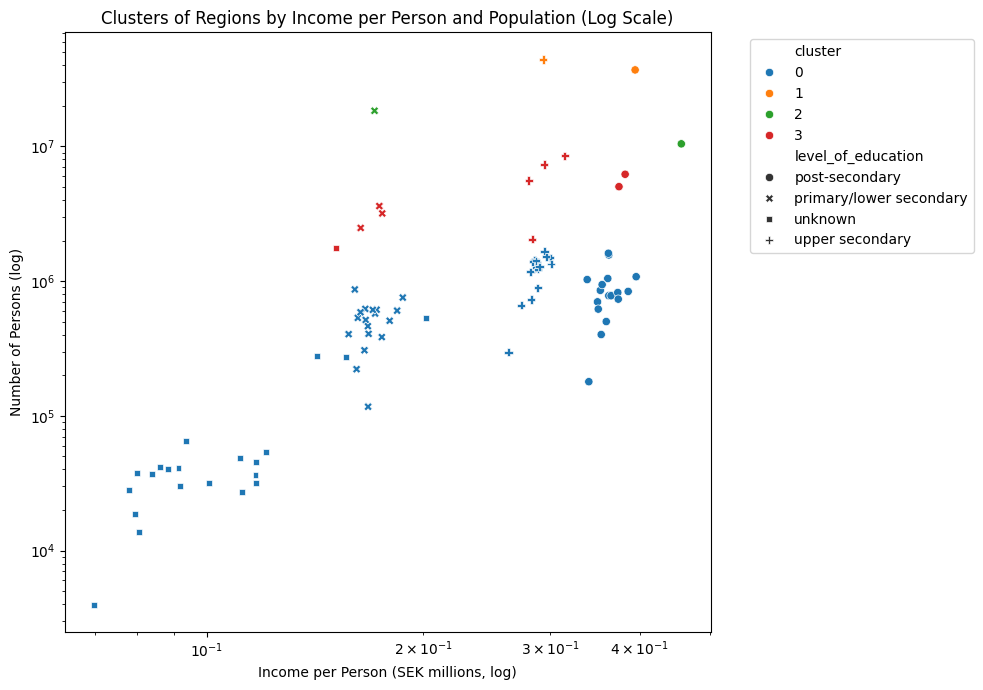

In [40]:
agg = (
    data.groupby(["region_name", "level_of_education"])
    .agg({"total_sum_sek_millions": "sum", "number_of_persons": "sum"})
    .reset_index()
)

agg["income_per_person"] = agg["total_sum_sek_millions"] / agg["number_of_persons"]

X_agg = agg[["income_per_person", "number_of_persons"]].fillna(0)

gmm = GaussianMixture(n_components=4, random_state=42)
agg["cluster"] = gmm.fit_predict(X_agg)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="income_per_person", y="number_of_persons", hue="cluster", style="level_of_education", data=agg, palette="tab10"
)
plt.xscale("log")
plt.yscale("log")
plt.title("Clusters of Regions by Income per Person and Population (Log Scale)")
plt.xlabel("Income per Person (SEK millions, log)")
plt.ylabel("Number of Persons (log)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [341]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.7, random_state=42, stratify=labels, shuffle=True)

X_train

,sex,income_bracket,year,total_sum_sek_millions,number_of_persons,region_name,level_of_education
113665,Man,220-239,2020,17.3,75,Uppsala,post-secondary
346363,Man,400-499,2013,124.8,285,Dalarna,primary/lower secondary
261373,Man,1000+,2015,9.1,7,Värmland,primary/lower secondary
38648,Woman,140-159,2011,60.9,407,Blekinge,upper secondary
262689,Man,120-139,2015,13.5,103,Örebro,primary/lower secondary
...,...,...,...,...,...,...,...
114658,Man,320-339,2020,56.1,170,Södermanland,upper secondary
65106,Man,180-199,2023,2.9,15,Gotland,post-secondary
355475,Man,120-139,2022,19.6,149,Uppsala,upper secondary
348529,Woman,500-599,2013,33.0,61,Gävleborg,post-secondary


In [342]:
y_train

,age
113665,6
346363,5
261373,6
38648,6
262689,6
...,...
114658,6
65106,6
355475,2
348529,6


Catagorical features

In [343]:
cat_features = features.drop(columns=["year", "total_sum_sek_millions", "number_of_persons"]).columns.to_list()

cat_features

['sex', 'income_bracket', 'region_name', 'level_of_education']

In [344]:
HGB_clf = HistGradientBoostingClassifier(
    loss="log_loss", learning_rate=0.1, max_iter=100, categorical_features=cat_features, l2_regularization=0, validation_fraction=0.1, n_iter_no_change=10, verbose=1, random_state=42
).fit(X=X_train, y=y_train)

Binning 0.014 GB of training data: 0.041 s
Binning 0.002 GB of validation data: 

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 8.004 s, (24800 total leaves)
Time spent computing histograms: 2.211s
Time spent finding best splits:  0.378s
Time spent applying splits:      1.565s
Time spent predicting:           0.346s


In [388]:
y_pred_bad = HGB_clf.predict(X=X_test)

In [389]:
print(classification_report(y_test, y_pred_bad))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      6468
           1       0.50      0.56      0.53     16461
           2       0.41      0.37      0.39     16942
           3       0.35      0.27      0.31     16479
           4       0.42      0.32      0.36     15953
           5       0.43      0.52      0.47     15176
           6       0.37      0.45      0.41     15033
           7       0.50      0.50      0.50     14442

    accuracy                           0.45    116954
   macro avg       0.47      0.47      0.47    116954
weighted avg       0.44      0.45      0.44    116954



In [390]:
HGB_clf.score(X=X_test, y=y_test)

0.44513227422747403

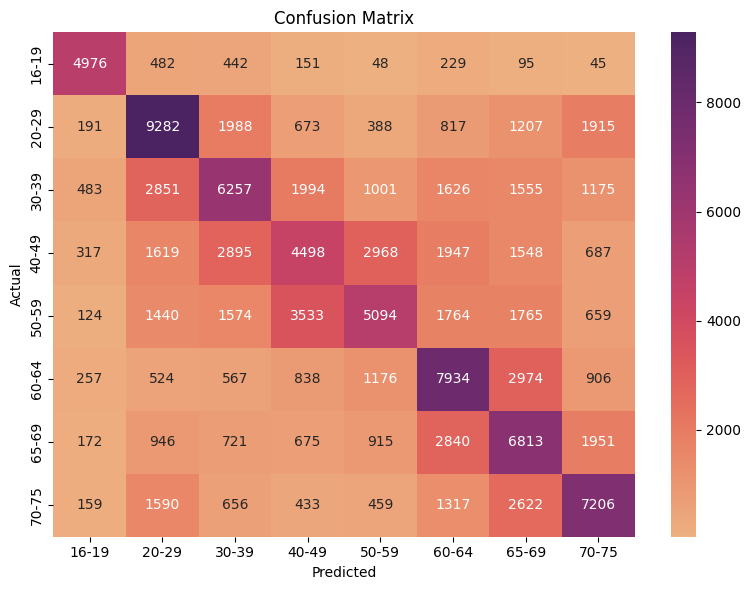

In [393]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_bad)

labels_names = ["16-19", "20-29", "30-39", "40-49", "50-59", "60-64", "65-69", "70-75"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="flare", xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [250]:
scores = cross_val_score(HGB_clf, features, labels, cv=5)
scores.mean()

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.047 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.147 s, (24800 total leaves)
Time spent computing histograms: 2.568s
Time spent finding best splits:  0.402s
Time spent applying splits:      1.842s
Time spent predicting:           0.410s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.113 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 9.733 s, (24800 total leaves)
Time spent computing histograms: 2.731s
Time spent finding best splits:  0.421s
Time spent applying splits:      1.908s
Time spent predicting:           0.436s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.043 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 11.352 s, (24800 total leaves)
Time spent computing histograms: 3.333s
Time spent finding best splits:  0.503s
Time spent applying splits:      2.286s
Time spent predicting:           0.504s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.042 s
Binning 0.002 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 12.082 s, (24800 total leaves)
Time spent computing histograms: 3.556s
Time spent finding best splits:  0.546s
Time spent applying splits:      2.398s
Time spent predicting:           0.526s


/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Binning 0.017 GB of training data: 0.053 s
Binning 0.002 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
Fit 800 trees in 11.398 s, (24800 total leaves)
Time spent computing histograms: 3.260s
Time spent finding best splits:  0.495s
Time spent applying splits:      2.237s
Time spent predicting:           0.491s


0.4342300737917217

Tuning

In [251]:
# Parameter Suggested Range:

learning_rate = [0.01, 0.05, 0.1, 0.2]
max_iter = [100, 300, 500, 1000]
max_leaf_nodes = [10, 20, 31, 50, 100] # default = 31
max_depth = [3, 5, 8, None]
min_samples_leaf = [1, 5, 10, 20, 50]
l2_regularization = [0, 1e-3, 1e-2, 1e-1, 1]
max_features = [0.3, 0.5, 0.7, 1.0]
validation_fraction = [0.1, 0.2]
n_iter_no_change = [5, 10, 20]

In [ ]:
param_grid = [
    {
        "learning_rate": learning_rate,
        # "max_iter": max_iter,
        "max_leaf_nodes": max_leaf_nodes,
        "max_depth": max_depth,
        "min_samples_leaf": min_samples_leaf,
        "l2_regularization": l2_regularization,
        # "max_features": max_features,
        # "validation_fraction": validation_fraction,
        # "n_iter_no_change": n_iter_no_change,
    }
]

In [349]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = RandomizedSearchCV(
    HistGradientBoostingClassifier(verbose=1, categorical_features=cat_features),
    param_grid,
    random_state=42,
    verbose=1,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
)
search = clf.fit(features, labels.squeeze())
search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Binning 0.016 GB of training data: Binning 0.016 GB of training data: Binning 0.016 GB of training data: 0.202 s
Binning 0.002 GB of validation data: 0.020 s
Fitting gradient boosted rounds:
0.208 s
Binning 0.002 GB of validation data: 0.013 s
Fitting gradient boosted rounds:
Binning 0.016 GB of training data: Binning 0.016 GB of training data: 0.356 s
Binning 0.002 GB of validation data: Binning 0.016 GB of training data: 0.020 s
Fitting gradient boosted rounds:
0.200 s
Binning 0.002 GB of validation data: 0.020 s
Fitting gradient boosted rounds:
0.307 s
Binning 0.002 GB of validation data: 0.363 s
Binning 0.002 GB of validation data: 0.014 s
Fitting gradient boosted rounds:
0.033 s
Fitting gradient boosted rounds:
Binning 0.016 GB of training data: Binning 0.016 GB of training data: 0.187 s
Binning 0.002 GB of validation data: 0.015 s
Fitting gradient boosted rounds:
0.230 s
Binning 0.002 GB of validation data: 0.014 s
Fitt


{
    'min_samples_leaf': 1,
    'max_leaf_nodes': 100,
    'max_depth': None,
    'learning_rate': 0.1,
    'l2_regularization': 0.01
}

In [350]:
search.best_estimator_

HistGradientBoostingClassifier(categorical_features=['sex', 'income_bracket',
                                                     'region_name',
                                                     'level_of_education'],
                               l2_regularization=0.01, max_leaf_nodes=100,
                               min_samples_leaf=1, verbose=1)

In [386]:
model = search.best_estimator_
model.fit(X_train, y_train)
y_pred_better = model.predict(X_test)

Binning 0.014 GB of training data: 0.041 s
Binning 0.002 GB of validation data: 

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 13.061 s, (80000 total leaves)
Time spent computing histograms: 3.439s
Time spent finding best splits:  1.177s
Time spent applying splits:      3.132s
Time spent predicting:           0.460s


In [387]:
print(classification_report(y_pred_better, y_test))

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      6899
           1       0.61      0.54      0.57     18640
           2       0.43      0.46      0.45     15730
           3       0.30      0.39      0.34     12689
           4       0.38      0.46      0.41     13147
           5       0.57      0.49      0.53     17650
           6       0.48      0.41      0.44     17842
           7       0.55      0.55      0.55     14357

    accuracy                           0.49    116954
   macro avg       0.52      0.51      0.51    116954
weighted avg       0.50      0.49      0.50    116954



In [361]:
scores = cross_val_score(model, features, labels, cv=5)
scores.mean()

Binning 0.016 GB of training data: 0.046 s
Binning 0.002 GB of validation data: 

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 13.088 s, (80000 total leaves)
Time spent computing histograms: 3.082s
Time spent finding best splits:  0.935s
Time spent applying splits:      2.439s
Time spent predicting:           0.440s
Binning 0.016 GB of training data: 0.043 s
Binning 0.002 GB of validation data: 

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 14.575 s, (80000 total leaves)
Time spent computing histograms: 4.118s
Time spent finding best splits:  1.291s
Time spent applying splits:      3.332s
Time spent predicting:           0.527s
Binning 0.016 GB of training data: 0.040 s
Binning 0.002 GB of validation data: 

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 15.158 s, (80000 total leaves)
Time spent computing histograms: 4.180s
Time spent finding best splits:  1.314s
Time spent applying splits:      3.633s
Time spent predicting:           0.559s
Binning 0.016 GB of training data: 0.039 s
Binning 0.002 GB of validation data: 

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 14.032 s, (80000 total leaves)
Time spent computing histograms: 3.928s
Time spent finding best splits:  1.229s
Time spent applying splits:      3.213s
Time spent predicting:           0.550s
Binning 0.016 GB of training data: 0.045 s
Binning 0.002 GB of validation data: 

/home/joel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.003 s
Fitting gradient boosted rounds:
Fit 800 trees in 16.042 s, (80000 total leaves)
Time spent computing histograms: 4.529s
Time spent finding best splits:  1.439s
Time spent applying splits:      3.650s
Time spent predicting:           0.593s


0.48243406361176805

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_better)

labels_names = ["16-19", "20-29", "30-39", "40-49", "50-59", "60-64", "65-69", "70-75"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Making some feature importance searching and all features seem to be useful for the model.

In [362]:
pi = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
pi["importances_mean"]


array([0.08294201, 0.2459685 , 0.06584811, 0.20329018, 0.2685449 ,
       0.21230142, 0.21641757])

In [363]:
pd.DataFrame([features.columns, pi["importances_mean"]]).T.set_index(0)

,1
0,
sex,0.082942
income_bracket,0.245969
year,0.065848
total_sum_sek_millions,0.20329
number_of_persons,0.268545
region_name,0.212301
level_of_education,0.216418


Which class is of a majority? I will predict only the majority class and see which accuracy I can achieve. Probably to many classes for this to be useful but will do it anyway.

In [371]:
y_train.value_counts()


age
2      39532
3      38452
1      38408
4      37224
5      35410
6      35075
7      33698
0      15091
Name: count, dtype: int64

Class 2 is of majority but of course only predicting class two will yield approximately 1/8 accuracy.

In [421]:
y_majority = [2] * len(y_test)
accuracy_score(y_true=y_test, y_pred=y_majority)

0.14486037245412725

**3. Change your train/test data** (e.g. `X_train`, `X_test`) **to only include the _two most important features_.** Then retrain the model with that & evaluate it again. Did the accuracy score change?

**4. Do the same thing, but train the model on the _two least important features only_.** What accuracy score do you expect? See if the result matches your expectation.

**6. Which of our measurement variables are _normally distributed_?** Checking for a normal distribution is useful, because it is often a requirement for using other metrics that the data is normally distributed.

In [364]:
pg.normality(data)

/home/joel/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 389844.
  res = hypotest_fun_out(*samples, **kwds)
/home/joel/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 389844.
  res = hypotest_fun_out(*samples, **kwds)
/home/joel/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 389844.
  res = hypotest_fun_out(*samples, **kwds)


,W,pval,normal
age,0.935780,2.566071e-126,False
year,0.943760,1.941717e-122,False
total_sum_sek_millions,0.118112,1.793411e-215,False
number_of_persons,0.184068,1.753375e-212,False


**7. Which of the measurement variables are _correlated_?** Perform a pairwise correlation analysis with all the columns of our dataframe. Use Pearson correlation if the variables are normally distributed, and Spearman correlation if not.

In [365]:
pg.pairwise_corr(data, method="pearson")

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,age,year,pearson,two-sided,389844,-0.015268,"[-0.02, -0.01]",1.522331e-21,1.092e+17,1.000
1,age,total_sum_sek_millions,pearson,two-sided,389844,-0.014889,"[-0.02, -0.01]",1.450319e-20,1.174e+16,1.000
2,age,number_of_persons,pearson,two-sided,389844,-0.054089,"[-0.06, -0.05]",2.233934e-250,2.115e+245,1.000
3,year,total_sum_sek_millions,pearson,two-sided,389844,0.018018,"[0.01, 0.02]",2.285650e-29,6.178e+24,1.000
4,year,number_of_persons,pearson,two-sided,389844,-0.003002,"[-0.01, 0.0]",6.086493e-02,0.012,0.466
5,total_sum_sek_millions,number_of_persons,pearson,two-sided,389844,0.810655,"[0.81, 0.81]",0.000000e+00,inf,1.000


**Make a new Pandas DataFrame with "classifier correctness" labels.** This DataFrame should have:

- One **column per classifier**, e.g. the "bad" classifier before hyperparameter tuning, the "better" classifier from after tuning, and the "majority" classifier.
- One **row per instance in your test set**.
- A value of **`True` or `False` in each cell**, depending on whether the classifier _(column)_ correctly classified the instance _(row)_ or not.

Your resulting DataFrame could look something like this:

|       | **better** | **bad**  | **majority** |
|-------|----------|----------|--------------|
| **0** | True     | False    | False        |
| **1** | True     | False    | False        |
| **2** | True     | True     | True         |
| ...   | ...      | ...      | ...          |

In [422]:
y_majority_df = pd.DataFrame(
    y_majority,
    index=X_test.index,
    columns=["age"],
)
y_majority_df

,age
180857,2
234529,2
16578,2
252931,2
293568,2
...,...
234736,2
3371,2
407777,2
78508,2


In [423]:
y_pred_better_df = pd.DataFrame(
    y_pred_better,
    index=X_test.index,
    columns=["age"],
)
y_pred_better_df

,age
180857,7
234529,5
16578,1
252931,5
293568,7
...,...
234736,7
3371,0
407777,6
78508,3


In [424]:
y_pred_bad_df = pd.DataFrame(
    y_pred_bad,
    index=X_test.index,
    columns=["age"],
)
y_pred_bad_df

,age
180857,7
234529,5
16578,1
252931,5
293568,7
...,...
234736,7
3371,0
407777,5
78508,3


In [429]:
df_eval = pd.DataFrame(
    {
        "better": y_pred_better_df["age"] == y_test["age"],
        "bad": y_pred_bad_df["age"] == y_test["age"],
        "majority": y_majority_df["age"] == y_test["age"],
    }
)
df_eval

,better,bad,majority
180857,True,True,False
234529,False,False,False
16578,False,False,False
252931,False,False,False
293568,False,False,False
...,...,...,...
234736,True,True,False
3371,True,True,False
407777,True,False,False
78508,True,True,False


**Is the "bad" model (no hyperparameter tuning) still significantly better than the "majority" class model?**

We answer this question by using **McNemar's test,** using a significance level of $0.05$.  This means that if McNemar's test gives us a $p$-value $< 0.05$, we accept that there is a significant difference between our two classifiers.

In [430]:
observed, stats = pg.chi2_mcnemar(df_eval, "bad", "majority")
stats

,chi2,dof,p-approx,p-exact
mcnemar,21831.25069,1,0.0,0.0


**Is the "better" model (from after tuning) significantly better than the "bad" model (from before tuning)?**  Same as above, just comparing different columns.

In [431]:
observed, stats = pg.chi2_mcnemar(df_eval, "better", "bad")
stats

,chi2,dof,p-approx,p-exact
mcnemar,1255.704719,1,4.778989e-275,1.148580e-277


**Perform a principal component analysis (PCA).** Two dimensions are a common choice to make them suitable for visualization.

Plot the result


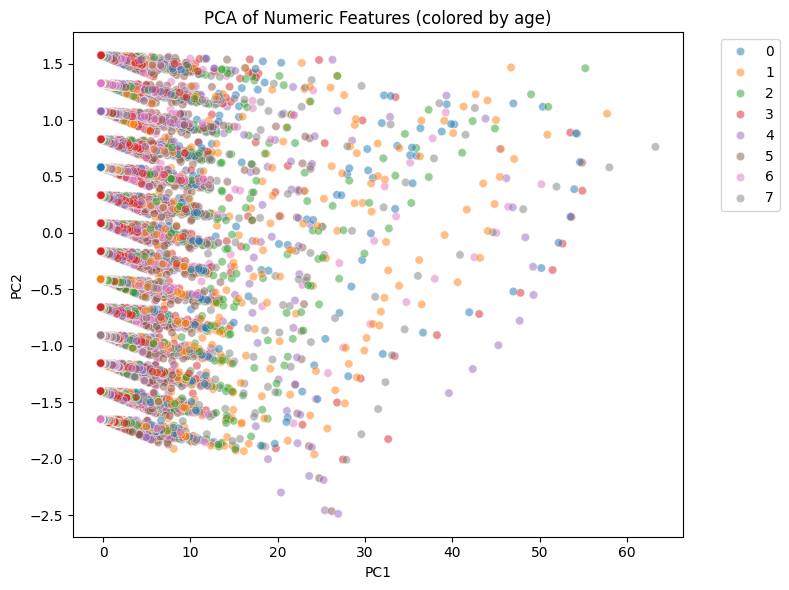

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select numeric columns
numeric_cols = ["year", "total_sum_sek_millions", "number_of_persons"]
X_numeric = data[numeric_cols].dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Make a DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
# Optionally add a label for coloring, e.g., age
pca_df["age"] = data.loc[X_numeric.index, "age"].astype(str)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="age", data=pca_df, palette="tab10", alpha=0.5)
plt.title("PCA of Numeric Features (colored by age)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()